In [2]:
import numpy as np
import scipy.stats as si
import math as m
import pandas as pd
import matplotlib.pyplot as plt

## 定义用于计算希腊字母的函数集：

In [17]:
r=q=0.23475#无风险利率和股息
sigma=0.2189#9月27号的60天波动率
t=31#到期天数
u=3.247#9月27日50etf指数收盘价
np.random.seed(123)
s=np.random.normal(u,sigma,500)#生成500个服从标准正态分布的标的价格
s=s[s<=3.5]
s=s[s>=2.9]
s.sort()#排序

def d1(s,k):
    d1=(np.log(s/k)+(r-q+sigma**2/2)*(t/365))/(sigma*np.sqrt(t/365))
    return d1

def delta(d1,s,k,sign):
    if sign==-1:
        delta=np.exp(-q*t/365)*(si.norm.cdf(d1)+sign)
    else:
        delta=np.exp(-q*t/365)*(si.norm.cdf(d1))
    return delta

def gamma(d1,s,k):
    gamma=np.exp(-q*t/365)*si.norm.pdf(d1)/(s*sigma*m.sqrt(t/365))
    return gamma

def vega(d1,s,k):
    vega=s*np.exp(-q*t/365)*si.norm.pdf(d1)*m.sqrt(t/365)/100
    return vega

def theta(d1,s,k,sign):
    d2=d1-sigma*m.sqrt(t/365)

    theta1=-s*np.exp(-q*t/365)*si.norm.pdf(d1)*sigma/2/m.sqrt(t/365)
    theta2=sign*q*s*np.exp(-q*t/365)*si.norm.cdf(sign*d1)
    theta3=-sign*r*k*m.exp(-r*m.sqrt(t/365))*si.norm.cdf(sign*d2)

    theta=theta1+theta2+theta3
    return theta/365

def greeks(s,k,sign):#sign=-1代表认沽期权,1代表认购期权
    D1=d1(s,k)
    Delta=delta(D1,s,k,sign)
    Gamma=gamma(D1,s,k)
    Vega=vega(D1,s,k)
    Theta=theta(D1,s,k,sign)
    return np.array([Delta,Gamma,Vega,Theta])

def plot_greeks(array,title):
    plt.plot(s,array,c='k')
    plt.title(title)
    plt.axvline(x=3.247,alpha=0.2,color='black')
    plt.text(x=3.247,y=np.min(array)+np.abs(0.1*np.min(array)),s='3.247',alpha=0.5)
    #plt.xlim(2.9,3.5)此段代码可以不用
    plt.ylim(bottom=np.min(array),top=np.max(array)*1.1)
    plt.grid(axis='y',alpha=0.5)

def portfolio_greeks(s,k1,k2,sign):
    delta,gamma,vega,theta=(greeks(s,k1,sign)-greeks(s,k2,sign))*10000

    Delta,Gamma,Vega,Theta=np.round((greeks(u,k1,sign)-greeks(u,k2,sign))*10000,2)
    print(f'期权组合：\ndelta={Delta}\ngamma={Gamma}\nvega={Vega}\ntheta={Theta}\n')

    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plot_greeks(delta,f'Delta={Delta}')
    
    plt.subplot(222)
    plot_greeks(gamma,f'Gamma={Gamma}')
    

    plt.subplot(223)
    plot_greeks(vega,f'Vega={Vega}')
    
    plt.subplot(224)
    plot_greeks(theta,f'Theta={Theta}')

## 定义用于计算盈亏分布的函数集：
bull_call代表牛市看涨，bear_put代表熊市看跌，exe_price1代表买入期权的执行价格，cost1代表买入期权的期权费。

In [4]:
def printf(x1,x2,x3,x4,profit1,profit2,profit3,profit4):

    print('期权组合的收益分布如下所示：','-'*100,sep='\n')
    print(f'当标的价格大于{x1}时，期权组合的收益为{profit1}','-'*100,sep='\n')
    print(f'当标的价格位于{x2}区间内，期权组合的收益区间为{profit2}','-'*100,sep='\n')
    print(f'当标的价格位于{x3}区间内，期权组合的收益区间为{profit3}','-'*100,sep='\n')
    print(f'当标的价格小于{x4}时，期权组合的收益为{profit4}\n\n\n')

def bull_call_distribution(exe_price1,cost1,exe_price2,cost2):#1表示买入期权，2表示卖出期权
    x1=exe_price2
    profit1=cost2-cost1+(exe_price2-exe_price1)*10000
    profit1=round(profit1,2)

    x2=((cost1-cost2+exe_price1*10000)/10000,exe_price2)
    profit2=(round(cost2-cost1+(exe_price2-exe_price1)*10000,2),0)

    x3=(exe_price1,(cost1-cost2+exe_price1*10000)/10000)
    profit3=(round(cost2-cost1,2),0)

    x4=exe_price1
    profit4=cost2-cost1
    profit4=round(profit4,2)

    printf(x1,x2,x3,x4,profit1,profit2,profit3,profit4)

def bull_put_distribution(exe_price1,cost1,exe_price2,cost2):#1表示买入期权，2表示卖出期权
    x1=exe_price2
    profit1=cost2-cost1
    profit1=round(profit1,2)

    x2=((cost1-cost2+exe_price2*10000)/10000,exe_price2)
    profit2=(0,round(cost2-cost1,2))

    x3=(exe_price1,(cost1-cost2+exe_price2*10000)/10000)
    profit3=(round(cost2-cost1+(exe_price1-exe_price2)*10000,2),0)

    x4=exe_price1
    profit4=cost2-cost1+(exe_price1-exe_price2)*10000
    profit4=round(profit4,2)

    printf(x1,x2,x3,x4,profit1,profit2,profit3,profit4)

def bear_call_distribution(exe_price1,cost1,exe_price2,cost2):#1表示买入期权，2表示卖出期权
    x1=exe_price1
    profit1=cost2-cost1+(exe_price2-exe_price1)*10000
    profit1=round(profit1,2)

    x2=((exe_price2*10000-cost1+cost2)/10000,exe_price1)
    profit2=(round(cost2-cost1+(exe_price2-exe_price1)*10000,2),0)

    x3=(exe_price2,(exe_price2*10000-cost1+cost2)/10000)
    profit3=(0,round(cost2-cost1,2))

    x4=exe_price2
    profit4=cost2-cost1
    profit4=round(profit4,2)

    printf(x1,x2,x3,x4,profit1,profit2,profit3,profit4)

def bear_put_distribution(exe_price1,cost1,exe_price2,cost2):#1表示买入期权，2表示卖出期权
    x1=exe_price1
    profit1=cost2-cost1
    profit1=round(profit1,2)

    x2=((exe_price1*10000-cost1+cost2)/10000,exe_price1)
    profit2=(round(cost2-cost1,2),0)

    x3=(exe_price2,(exe_price1*10000-cost1+cost2)/10000)
    profit3=(0,round(cost2-cost1+(exe_price1-exe_price2)*10000,2))

    x4=exe_price2
    profit4=cost2-cost1+(exe_price1-exe_price2)*10000
    profit4=round(profit4,2)

    printf(x1,x2,x3,x4,profit1,profit2,profit3,profit4)

## 案例一
2021年9月27日50ETF指数收盘价格为3.247，预计未来上证50ETF会呈现上涨趋势时，基于不同的风险收益考虑，应如何构造期权组合策略？
### 方案一：基于平值附近合约构建的牛市看涨价差组合，


基于平值附近合约的牛市看涨差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.3时，期权组合的收益为460.0
----------------------------------------------------------------------------------------------------
当标的价格位于(3.254, 3.3)区间内，期权组合的收益区间为(460.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.2, 3.254)区间内，期权组合的收益区间为(-540, 0)
----------------------------------------------------------------------------------------------------
当标的价格小于3.2时，期权组合的收益为-540



期权组合：
delta=1867.88
gamma=-170.48
vega=-0.33
theta=0.59



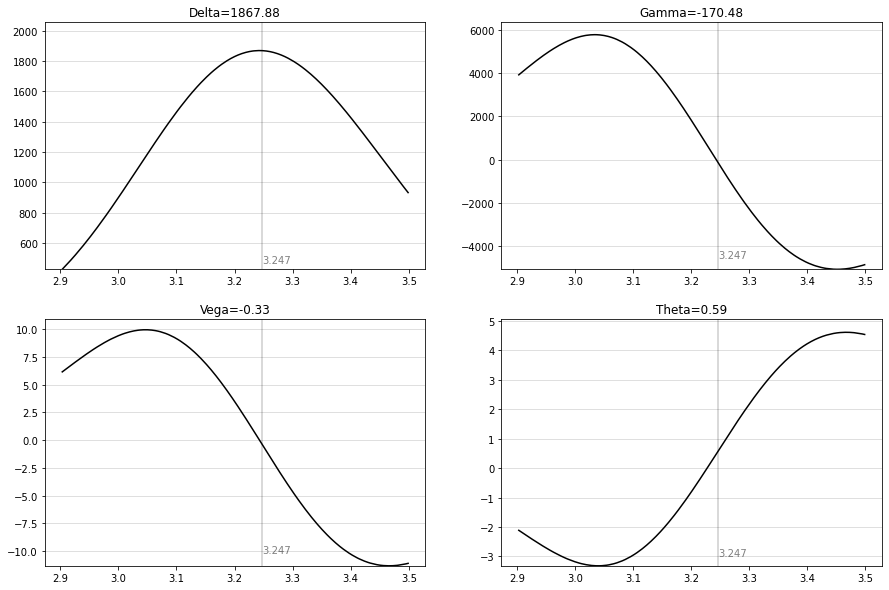

In [18]:
print('基于平值附近合约的牛市看涨差价组合',end=',')
bull_call_distribution(3.2,988,3.3,448)
portfolio_greeks(s,3.2,3.3,1)

### 方案二：基于实值附近合约构建的牛市看涨价差组合

基于实值附近合约的牛市看涨差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于2.95时，期权组合的收益为18.0
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9482, 2.95)区间内，期权组合的收益区间为(18.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9, 2.9482)区间内，期权组合的收益区间为(-482, 0)
----------------------------------------------------------------------------------------------------
当标的价格小于2.9时，期权组合的收益为-482



期权组合：
delta=261.43
gamma=-2094.58
vega=-4.11
theta=1.76



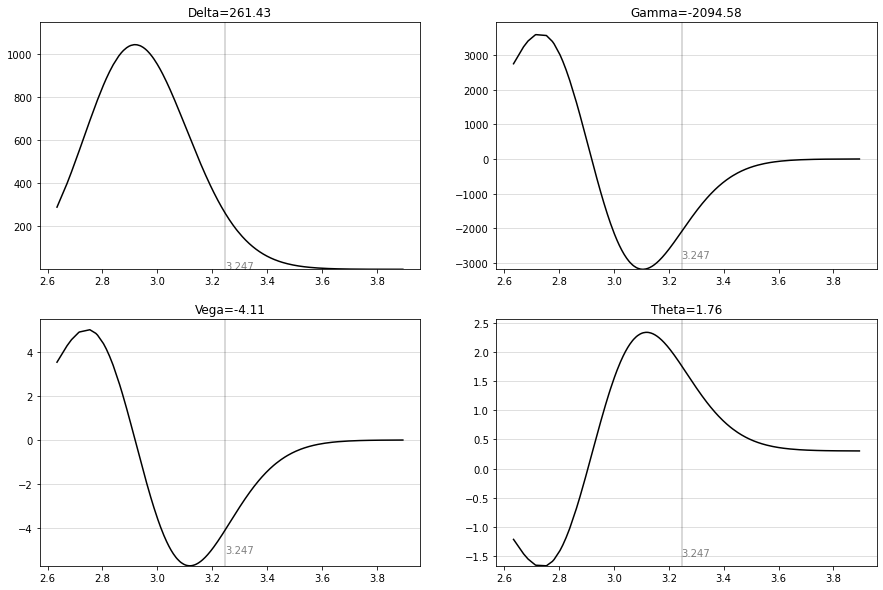

In [6]:
print('基于实值附近合约的牛市看涨差价组合',end=',')
bull_call_distribution(2.9,3475,2.95,2993)
portfolio_greeks(s,2.9,2.95,1)

### 方案三：基于虚值附近合约构建的牛市看涨价差组合

基于虚值附近合约构建的牛市看涨差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.5时，期权组合的收益为882.0
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4118, 3.5)区间内，期权组合的收益区间为(882.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4, 3.4118)区间内，期权组合的收益区间为(-118, 0)
----------------------------------------------------------------------------------------------------
当标的价格小于3.4时，期权组合的收益为-118



期权组合：
delta=1165.35
gamma=5071.38
vega=9.94
theta=-3.3



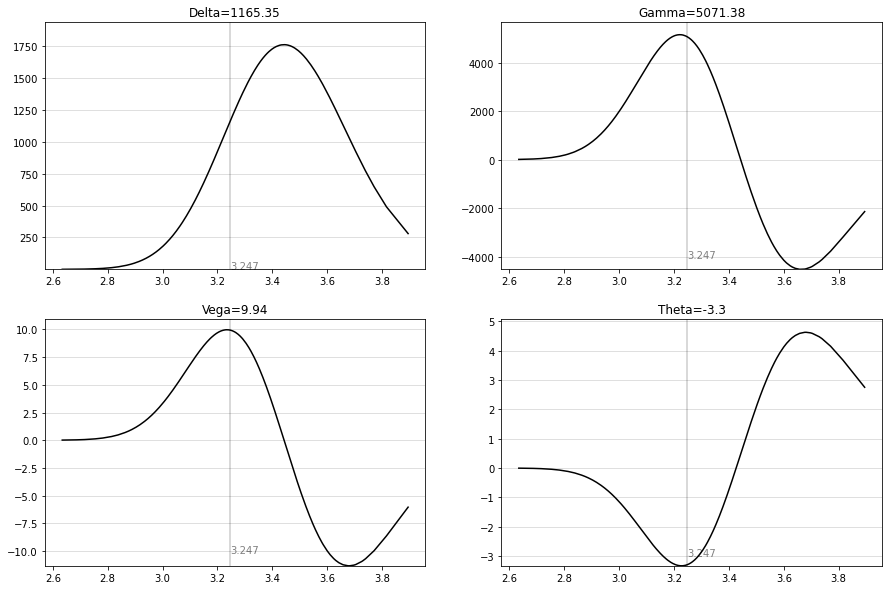

In [7]:
print('基于虚值附近合约构建的牛市看涨差价组合',end=',')
bull_call_distribution(3.4,185,3.5,67)
portfolio_greeks(s,3.4,3.5,1)

### 方案四：基于平值附近合约构建的牛市看跌价差组合

基于平值附近合约构建的牛市看跌差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.3时，期权组合的收益为485
----------------------------------------------------------------------------------------------------
当标的价格位于(3.2515, 3.3)区间内，期权组合的收益区间为(0, 485)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.2, 3.2515)区间内，期权组合的收益区间为(-515.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格小于3.2时，期权组合的收益为-515.0



期权组合：
delta=1867.88
gamma=-170.48
vega=-0.33
theta=-0.01



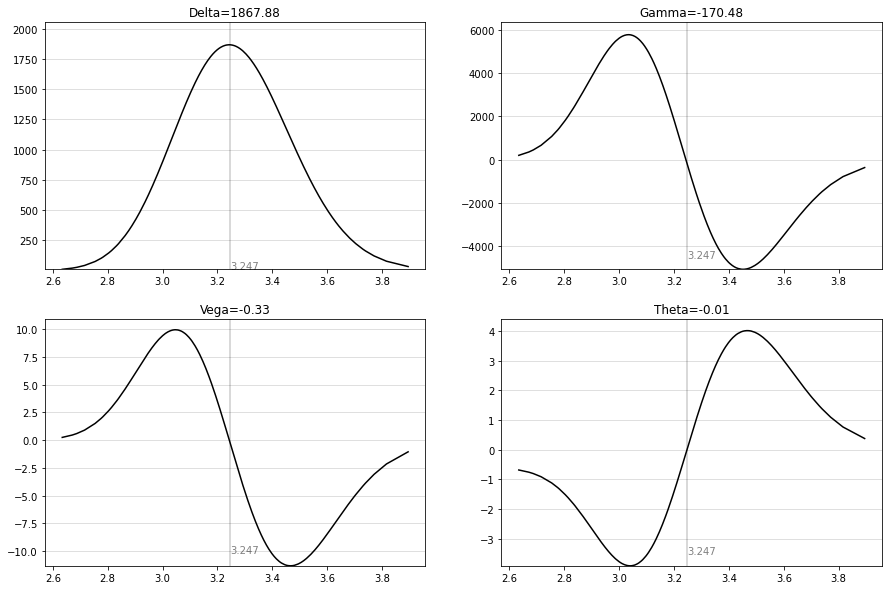

In [8]:
print('基于平值附近合约构建的牛市看跌差价组合',end=',')
bull_put_distribution(3.2,511,3.3,996)
portfolio_greeks(s,3.2,3.3,-1)

### 方案五：基于深度虚值附近合约构建的牛市看跌价差组合

基于深度虚值附近合约构建的牛市看跌差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于2.95时，期权组合的收益为18
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9482, 2.95)区间内，期权组合的收益区间为(0, 18)
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9, 2.9482)区间内，期权组合的收益区间为(-482.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格小于2.9时，期权组合的收益为-482.0



期权组合：
delta=261.43
gamma=-2094.58
vega=-4.11
theta=1.46



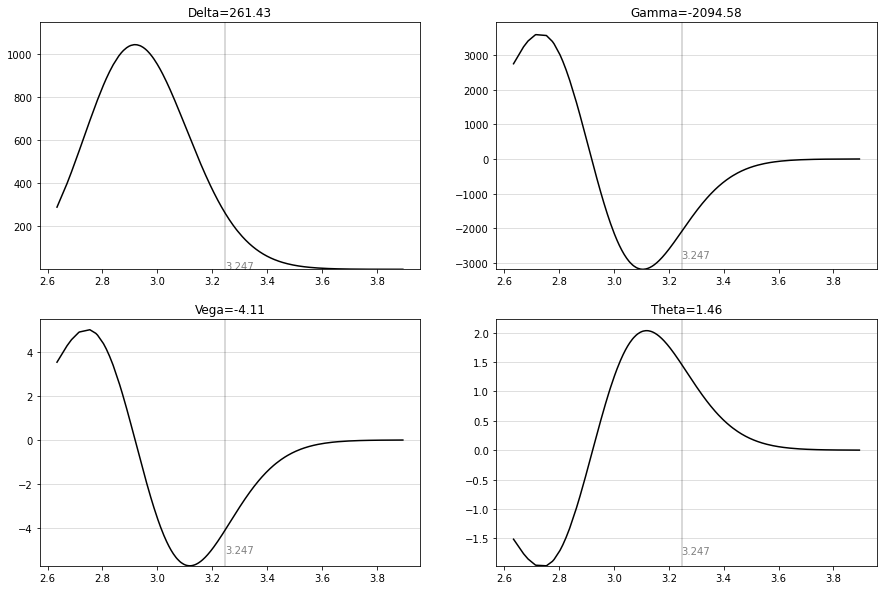

In [9]:
print('基于深度虚值附近合约构建的牛市看跌差价组合',end=',')
bull_put_distribution(2.9,40,2.95,58)
portfolio_greeks(s,2.9,2.95,-1)

### 方案六：基于深度实值附近合约构建的牛市看跌价差组合

基于深度实值附近合约构建的牛市看跌差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.5时，期权组合的收益为843
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4157, 3.5)区间内，期权组合的收益区间为(0, 843)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4, 3.4157)区间内，期权组合的收益区间为(-157.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格小于3.4时，期权组合的收益为-157.0



期权组合：
delta=1165.35
gamma=5071.38
vega=9.94
theta=-3.9



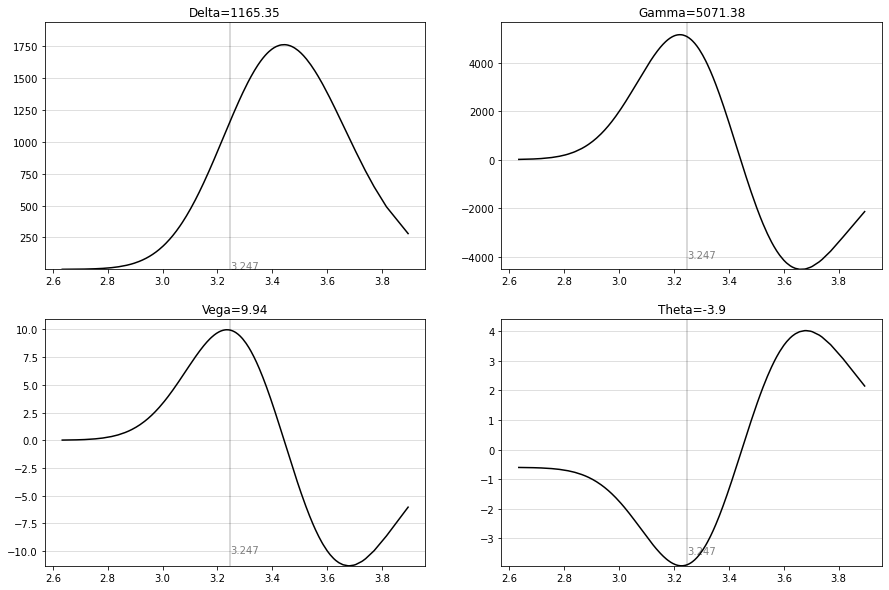

In [10]:
print('基于深度实值附近合约构建的牛市看跌差价组合',end=',')
bull_put_distribution(3.4,1780,3.5,2623)
portfolio_greeks(s,3.4,3.5,-1)

## 案例二：
2021年9月27日50ETF指数收盘价格为3.247，预计未来上证50ETF会呈现下涨趋势时，基于不同的风险收益考虑，应如何构造期权组合策略？
### 方案一：基于平值附近合约构建的熊市看涨价差组合

基于平值附近合约构建的熊市看涨差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.3时，期权组合的收益为-464.0
----------------------------------------------------------------------------------------------------
当标的价格位于(3.2536, 3.3)区间内，期权组合的收益区间为(-464.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.2, 3.2536)区间内，期权组合的收益区间为(0, 536)
----------------------------------------------------------------------------------------------------
当标的价格小于3.2时，期权组合的收益为536



期权组合：
delta=-1867.88
gamma=170.48
vega=0.33
theta=-0.59



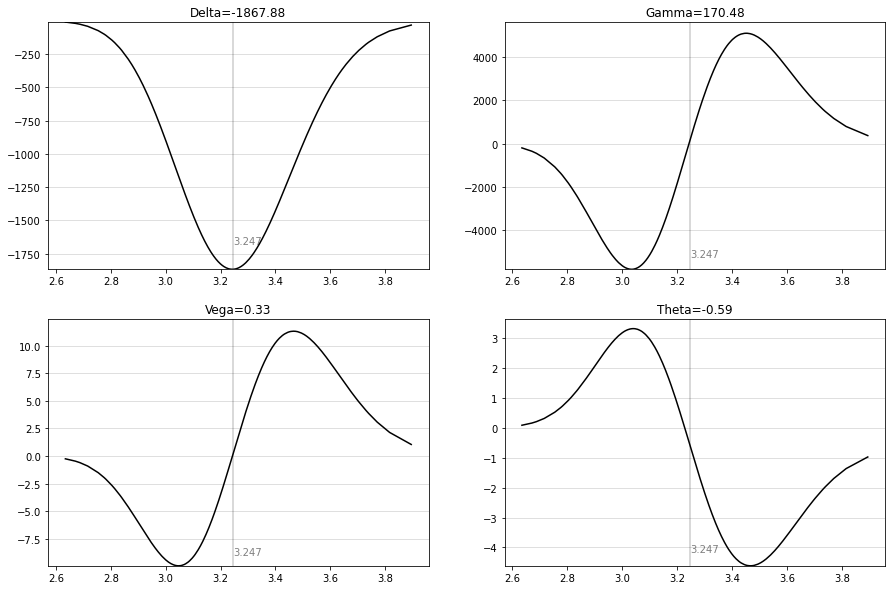

In [11]:
print('基于平值附近合约构建的熊市看涨差价组合',end=',')
bear_call_distribution(3.3,449,3.2,985)
portfolio_greeks(s,3.3,3.2,1)


### 方案二：基于实值附近合约构建的熊市看涨价差组合

基于实值附近合约构建的熊市看涨差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于2.95时，期权组合的收益为-46.0
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9454, 2.95)区间内，期权组合的收益区间为(-46.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9, 2.9454)区间内，期权组合的收益区间为(0, 454)
----------------------------------------------------------------------------------------------------
当标的价格小于2.9时，期权组合的收益为454



期权组合：
delta=-261.43
gamma=2094.58
vega=4.11
theta=-1.76



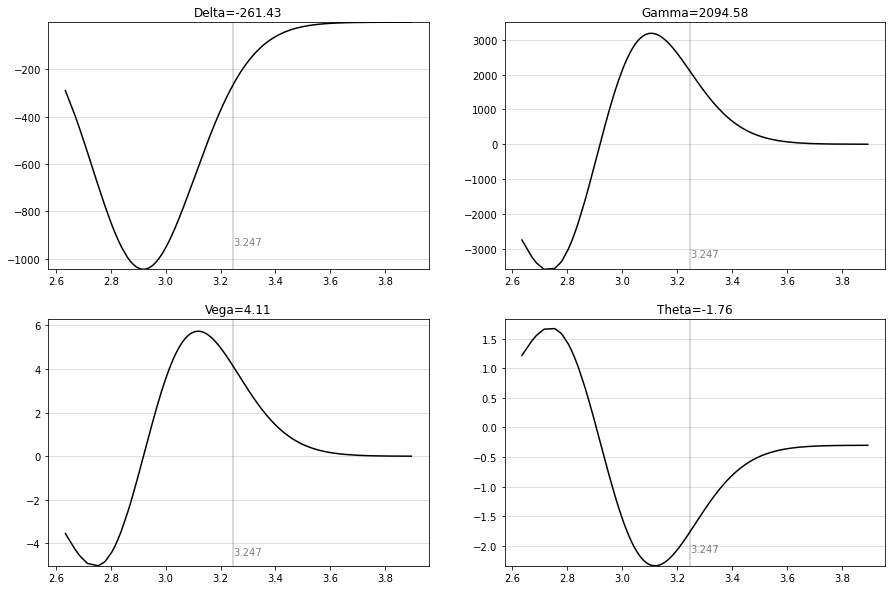

In [12]:
print('基于实值附近合约构建的熊市看涨差价组合',end=',')
bear_call_distribution(2.95,2994,2.9,3448)
portfolio_greeks(s,2.95,2.9,1)

### 方案三：基于虚值附近合约构建的熊市看涨价差组合

基于虚值附近合约构建的熊市看涨差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.5时，期权组合的收益为-885.0
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4115, 3.5)区间内，期权组合的收益区间为(-885.0, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4, 3.4115)区间内，期权组合的收益区间为(0, 115)
----------------------------------------------------------------------------------------------------
当标的价格小于3.4时，期权组合的收益为115



期权组合：
delta=-1165.35
gamma=-5071.38
vega=-9.94
theta=3.3



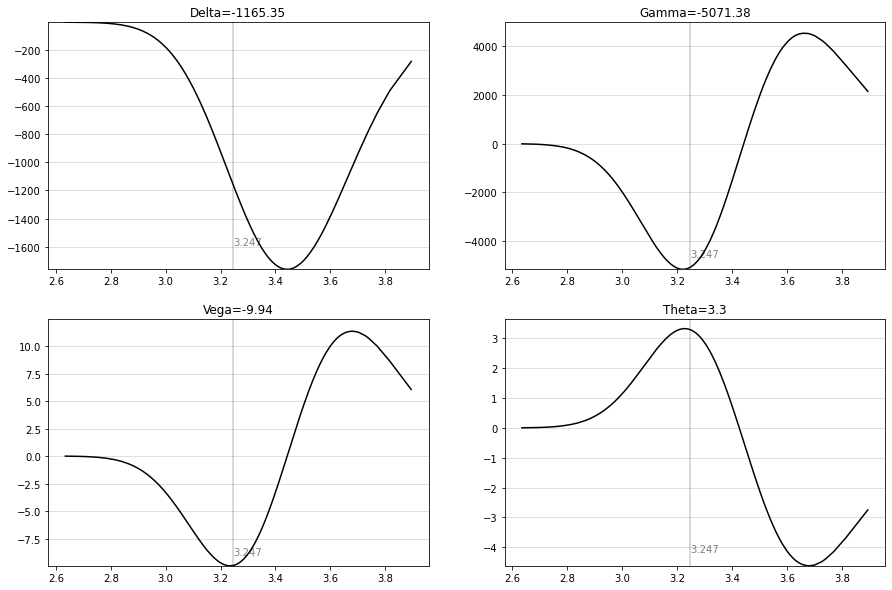

In [13]:
print('基于虚值附近合约构建的熊市看涨差价组合',end=',')
bear_call_distribution(3.5,69,3.4,184)
portfolio_greeks(s,3.5,3.4,1)

### 方案四：基于平值附近合约构建的熊市看跌价差组合

基于平值附近合约构建的熊市看跌差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.3时，期权组合的收益为-489
----------------------------------------------------------------------------------------------------
当标的价格位于(3.2511, 3.3)区间内，期权组合的收益区间为(-489, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.2, 3.2511)区间内，期权组合的收益区间为(0, 511.0)
----------------------------------------------------------------------------------------------------
当标的价格小于3.2时，期权组合的收益为511.0



期权组合：
delta=-1867.88
gamma=170.48
vega=0.33
theta=0.01



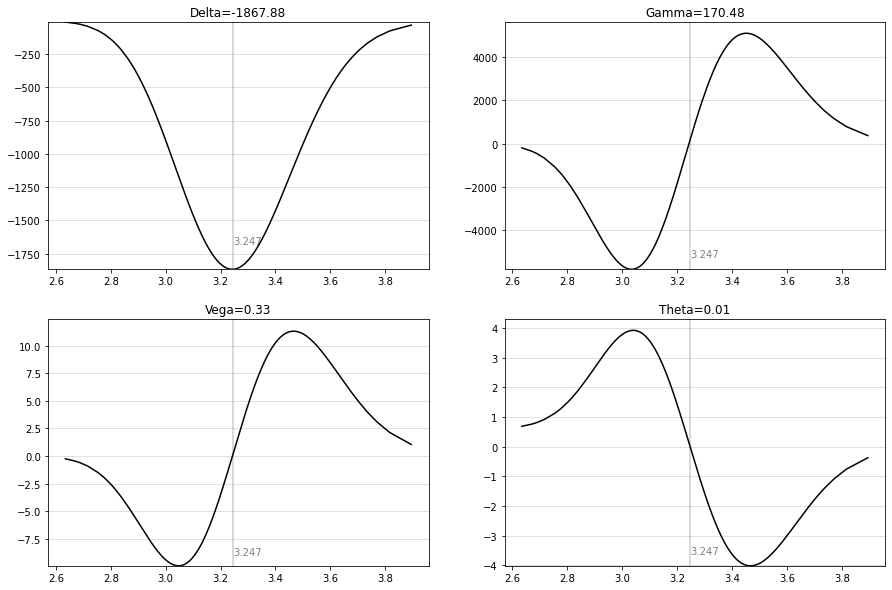

In [14]:
print('基于平值附近合约构建的熊市看跌差价组合',end=',')
bear_put_distribution(3.3,999,3.2,510)
portfolio_greeks(s,3.3,3.2,-1)


### 方案五：基于深度虚值附近合约构建的熊市看跌价差组合

基于深度虚值附近合约构建的熊市看跌差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于2.95时，期权组合的收益为-21
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9479, 2.95)区间内，期权组合的收益区间为(-21, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(2.9, 2.9479)区间内，期权组合的收益区间为(0, 479.0)
----------------------------------------------------------------------------------------------------
当标的价格小于2.9时，期权组合的收益为479.0



期权组合：
delta=-261.43
gamma=2094.58
vega=4.11
theta=-1.46



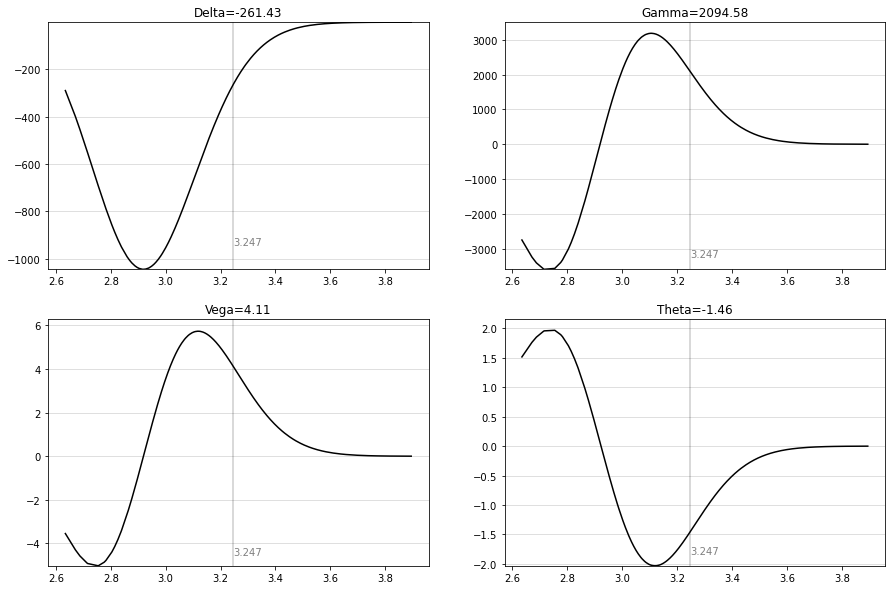

In [15]:
print('基于深度虚值附近合约构建的熊市看跌差价组合',end=',')
bear_put_distribution(2.95,60,2.9,39)
portfolio_greeks(s,2.95,2.9,-1)

### 方案六：基于深度实值附近合约构建的熊市看跌价差组合

基于深度附近合约构建的熊市看跌差价组合,期权组合的收益分布如下所示：
----------------------------------------------------------------------------------------------------
当标的价格大于3.5时，期权组合的收益为-871
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4129, 3.5)区间内，期权组合的收益区间为(-871, 0)
----------------------------------------------------------------------------------------------------
当标的价格位于(3.4, 3.4129)区间内，期权组合的收益区间为(0, 129.0)
----------------------------------------------------------------------------------------------------
当标的价格小于3.4时，期权组合的收益为129.0



期权组合：
delta=-1165.35
gamma=-5071.38
vega=-9.94
theta=3.9



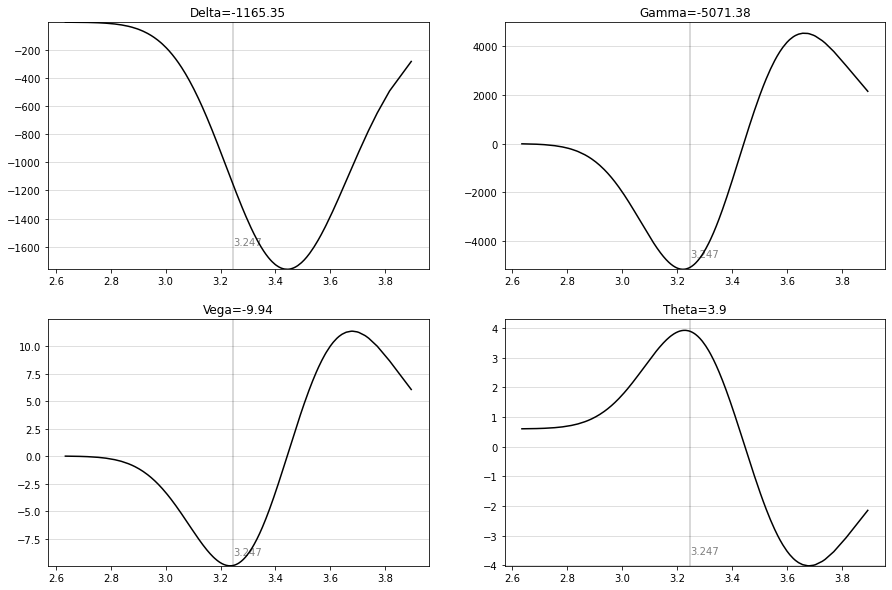

In [16]:
print('基于深度附近合约构建的熊市看跌差价组合',end=',')
bear_put_distribution(3.5,2631,3.4,1760)
portfolio_greeks(s,3.5,3.4,-1)